In [305]:
genome = open("SARS_COV_2.txt").read().replace("\n", "")
CODONS = [genome[i:i + 3] for i in range(0, len(genome), 3)]
CODONS = [codon for codon in CODONS if len(codon) == 3]

GENES = []
gene = []

STOP_CODONS = ['TAA', 'TAG', 'TGA']

for codon in CODONS:
    gene.append(codon)

    if codon in STOP_CODONS:
        GENES.append(gene)
        gene = []

In [306]:
len(GENES)

774

In [307]:
import json

codons_to_amino_acids = json.load(open("codons_to_amino_acids.json", "r"))

In [308]:
from markov_chain import MarkovChain

chains = [MarkovChain() for _ in range(len(GENES))]

In [309]:
for chain, gene in zip(chains, GENES):
    chain.fit(gene)

In [310]:
from dataclasses import dataclass

@dataclass
class CodonSelector:

    codons: list[str]
    
    def __hash__(self) -> int:
        
        return id(self)

    def random(self) -> str:

        return random.choice(self.codons)

def correct_codon(selectors: dict[CodonSelector, float]) -> str:

    return random.choices(
        list(selectors.keys()),
        weights=list(selectors.values()),
        k=1
    )[0]

In [311]:
DISTANCES: dict[str, dict[str, float]] = json.load(open("codons_distances.json", "r"))

BASE_CHAIN = MarkovChain()
BASE_CHAIN.load(DISTANCES)

In [312]:
from typing import Iterable

def generate_mutated_gene(
        chain: MarkovChain,
        gene: list[str],
        stop_codons: Iterable[str],
        correct: float = 1.0,
        closest: bool = False,
        selectors: dict[CodonSelector, float] = None
) -> list[str]:

    if selectors is None:
        selectors = {}

    mutated = [gene[0]]
    valid = gene[0]

    for i, codon in enumerate(gene[:-1]):
        new_codons = chain.forward(codon, 1, adjust=True)
        
        base = closest and ((not new_codons) or (new_codons[0] != gene[i + 1]))
        
        if base:
            distances = DISTANCES[gene[i + 1]]

            new_codons = random.choices(
                list(distances.keys()), 
                weights=list(distances.values()),
                k=1
            )

        mutated.append(
            new_codons[0]
            if new_codons else
            correct_codon({**selectors, CodonSelector([codon]): correct})
        )
        
        if base:
            valid = codon
        
        else:
            valid = mutated[-1]

        if mutated[-1] in stop_codons:
            break

    while mutated[-1] not in stop_codons:
        new_codons = chain.forward(valid, 1, adjust=True)

        mutated.append(new_codons[0] if new_codons else correct_codon(selectors))
        
        valid = mutated[-1]

    return mutated

In [313]:
import random

mutated_genes = []

CLOSEST = True
AUTO_CORRECT = 1
GENE_CODON = 0
GENOME_CODON = 0
STOP_CORRECT = 0

selectors = {
    CodonSelector(CODONS): GENOME_CODON,
    CodonSelector(STOP_CODONS): STOP_CORRECT
}

for i, (chain, original_gene) in enumerate(zip(chains, GENES)):
    mutated_genes.append(
        generate_mutated_gene(
            chain=chain,
            gene=original_gene,
            stop_codons=STOP_CODONS,
            correct=AUTO_CORRECT,
            closest=CLOSEST,
            selectors={**selectors, CodonSelector(original_gene): GENE_CODON}
        )
    )

In [314]:
from thefuzz import fuzz

for i, (original_gene, mutated_gene) in enumerate(zip(GENES, mutated_genes), start=1):
    print(f"gene no. {i}")
    print("original gene:   ", ' '.join(original_gene))
    print("mutated gene:    ", ' '.join(mutated_gene))
    print("original protein:", ' '.join([codons_to_amino_acids[codon] for codon in original_gene]))
    print("mutated protein: ", ' '.join([codons_to_amino_acids[codon] for codon in mutated_gene]))
    print("mutation rate:   ", (100 - fuzz.ratio(''.join(original_gene), ''.join(mutated_gene))) / 100)
    print()

gene no. 1
original gene:    ATT AAA GGT TTA TAC CTT CCC AGG TAA
mutated gene:     ATT AAA GGT TTA TAC CTT CCC AGG TAA
original protein: I K G L Y L P R *
mutated protein:  I K G L Y L P R *
mutation rate:    0.0

gene no. 2
original gene:    CAA ACC AAC CAA CTT TCG ATC TCT TGT AGA TCT GTT CTC TAA
mutated gene:     CAA ACC AAC CAA CTT TCG ATC TCT TGT AGA TCT TTA CTC TAA
original protein: Q T N Q L S I S C R S V L *
mutated protein:  Q T N Q L S I S C R S L L *
mutation rate:    0.02

gene no. 3
original gene:    ACG AAC TTT AAA ATC TGT GTG GCT GTC ACT CGG CTG CAT GCT TAG
mutated gene:     ACG AAC TTT AAA ATC TGT GTG GCT TCC ACT CGG CTG CAT GCT TAG
original protein: T N F K I C V A V T R L H A *
mutated protein:  T N F K I C V A S T R L H A *
mutation rate:    0.02

gene no. 4
original gene:    TGC ACT CAC GCA GTA TAA
mutated gene:     TGC ACT CAC GCA GTA TAA
original protein: C T H A V *
mutated protein:  C T H A V *
mutation rate:    0.0

gene no. 5
original gene:    TTA ATA ACT AAT T

In [315]:
size_to_gene_pairs: dict[int, list[tuple[str, str]]] = {}

for original_gene, mutated_gene in zip(GENES, mutated_genes):
    size_to_gene_pairs.setdefault(len(original_gene), []).append(
        (original_gene, mutated_gene)
    )

In [316]:
size_to_gene_ratios: dict[int, list[float]] = {}

for size, gene_pairs in size_to_gene_pairs.items():
    for original_gene, mutated_gene in gene_pairs:
        size_to_gene_ratios.setdefault(size, []).append(
            1 - fuzz.ratio(
                ''.join(codons_to_amino_acids[c] for c in original_gene),
                ''.join(codons_to_amino_acids[c] for c in mutated_gene)
            ) / 100
        )

In [317]:
size_to_gene_ratio: dict[int, float] = {
    size: sum(ratios) / len(ratios)
    for size, ratios in size_to_gene_ratios.items()
}

In [318]:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view

grouped_size_to_gene_ratios = {}
groups_limits = {}

GROUP_SIZE = 5

for sizes in sliding_window_view(
    np.array(sorted(size_to_gene_ratios.keys())), 
    window_shape=GROUP_SIZE
):
    size = sizes.mean()
    ratios = []
    
    for size in sizes:
        ratios.extend(size_to_gene_ratios[size])

    grouped_size_to_gene_ratios[size] = ratios
    groups_limits[size] = (sizes.min(), sizes.max())

In [319]:
grouped_size_to_gene_ratio: dict[int, float] = {
    size: sum(ratios) / len(ratios)
    for size, ratios in grouped_size_to_gene_ratios.items()
}

In [320]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")

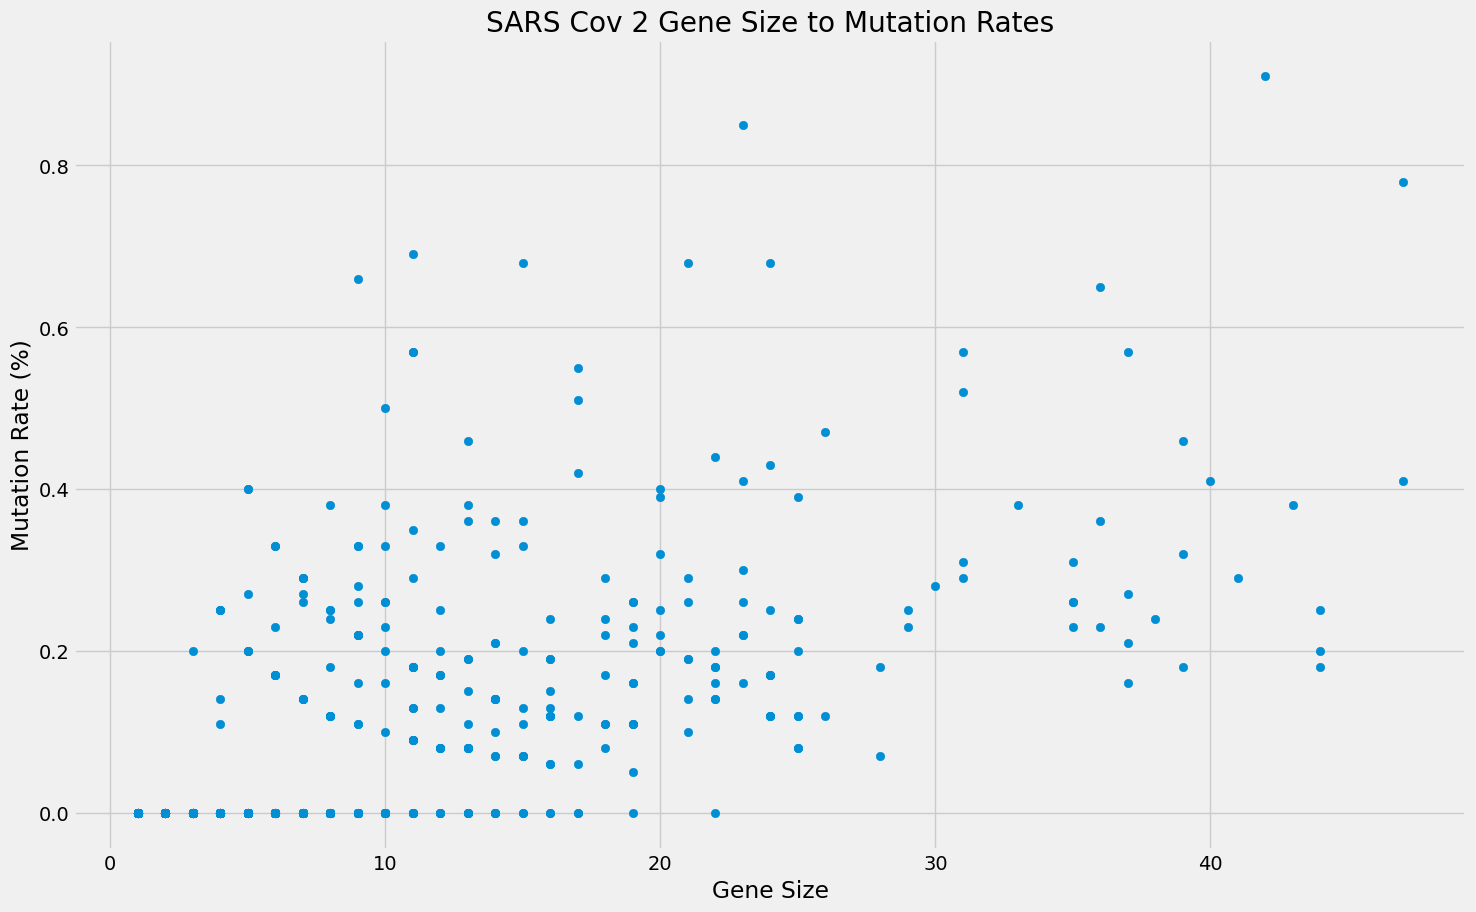

In [321]:
data = []

for size, ratios in sorted(size_to_gene_ratios.items(), key=lambda d: d[0]):
    for ratio in ratios:
        data.append((size, ratio))

points_data = np.array(data)

x, y = points_data[:, 0].astype(int), points_data[:, 1]

plt.figure(figsize=(16, 10))
plt.title("SARS Cov 2 Gene Size to Mutation Rates")
plt.xlabel("Gene Size")
plt.ylabel("Mutation Rate (%)")
plt.scatter(x[:-5], y[:-5])
plt.show()

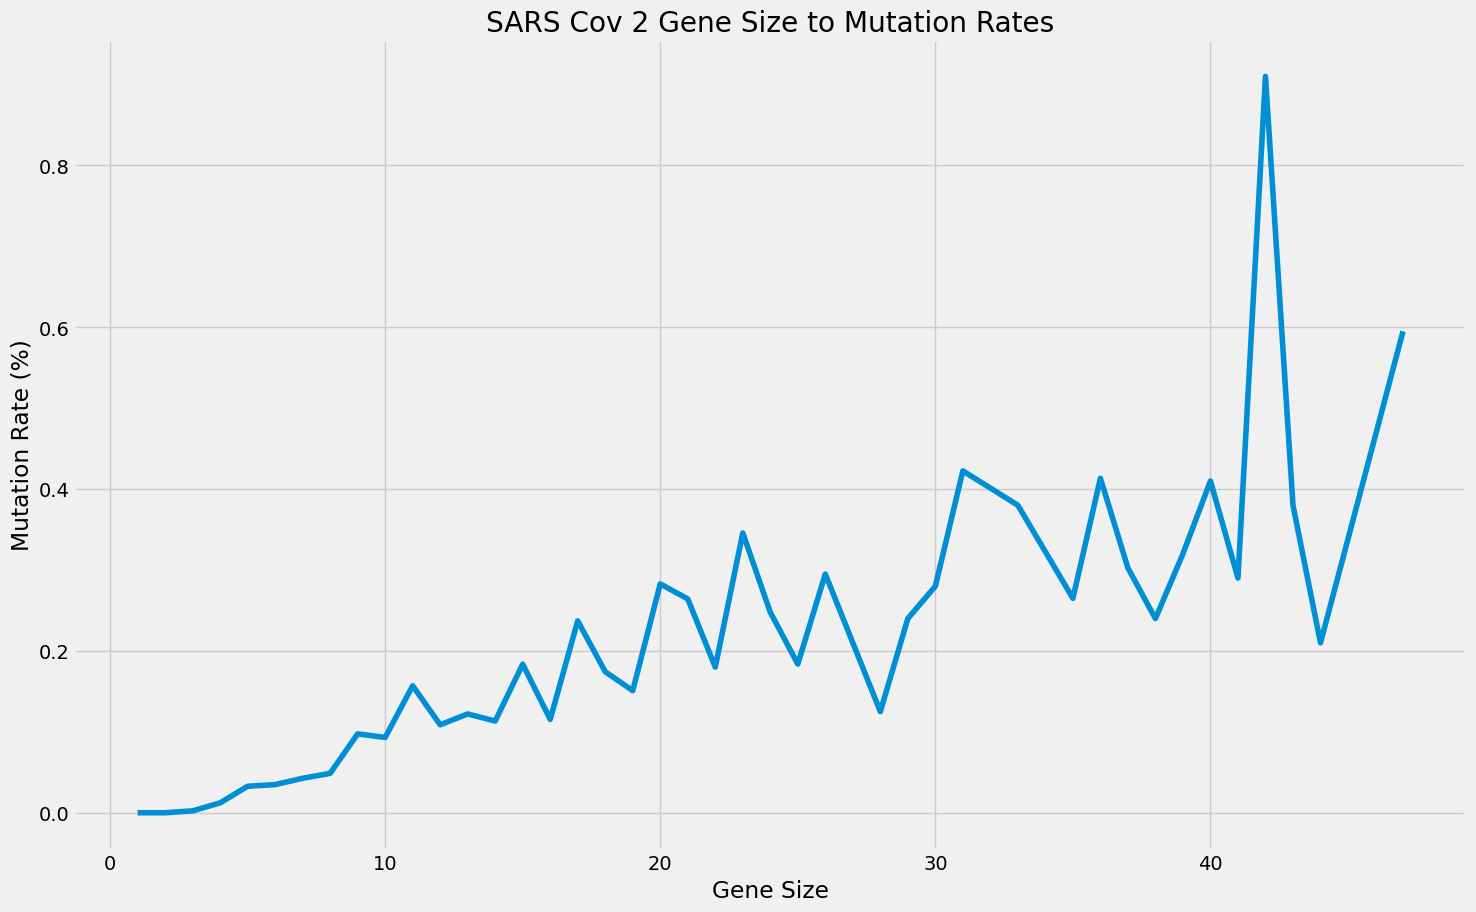

In [322]:
line_data = np.array(sorted(size_to_gene_ratio.items(), key=lambda d: d[0]))

x, y = line_data[:, 0].astype(int), line_data[:, 1]

plt.figure(figsize=(16, 10))
plt.title("SARS Cov 2 Gene Size to Mutation Rates")
plt.xlabel("Gene Size")
plt.ylabel("Mutation Rate (%)")
plt.plot(x[:-5], y[:-5])
plt.show()

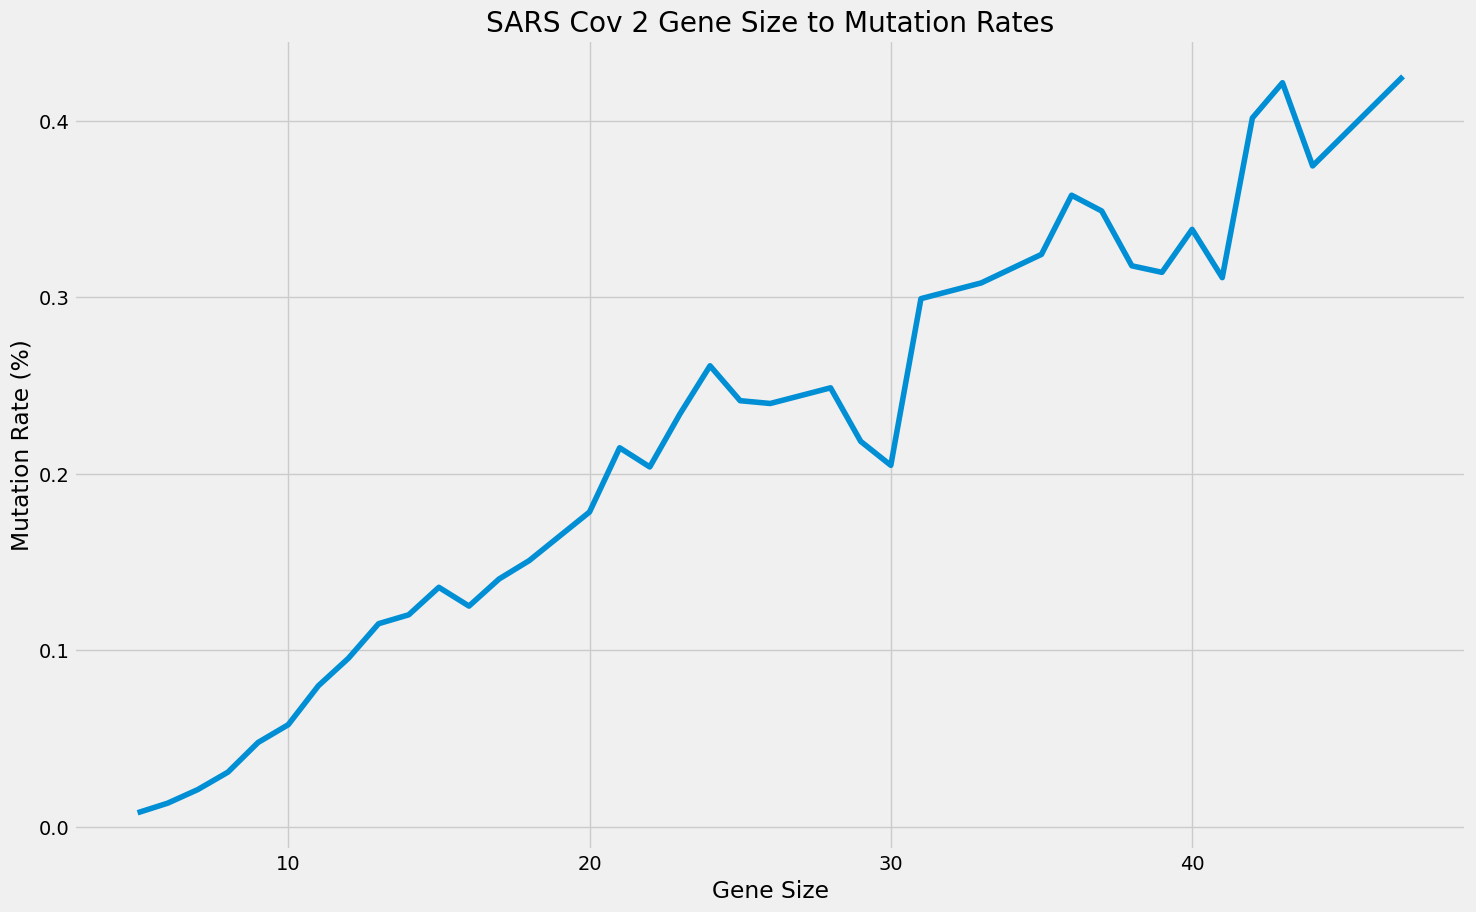

In [323]:
line_data = np.array(sorted(grouped_size_to_gene_ratio.items(), key=lambda d: d[0]))

x, y = line_data[:, 0].astype(int), line_data[:, 1]

plt.figure(figsize=(16, 10))
plt.title("SARS Cov 2 Gene Size to Mutation Rates")
plt.xlabel("Gene Size")
plt.ylabel("Mutation Rate (%)")
plt.plot(x[:-5], y[:-5])
plt.show()